In [36]:
import os
import os.path
import subject2initial
from scipy import signal, interpolate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy.spatial import distance
import scipy.stats as stats
from scipy import fftpack
from datetime import datetime
from datetime import timedelta
import pylab
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, normaltest, anderson
from functools import reduce
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [37]:
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks'))
    print(os.getcwd())
except:
    pass

strCurrentDirectory = os.getcwd()
print(strCurrentDirectory)

# "notebooks"ディレクトリよりも一階層上にいる場合はNotebooksフォルダに移動
if (strCurrentDirectory[-len("notebooks"):] != "notebooks") and (any("notebooks" in s for s in os.listdir())):
    os.chdir('notebooks')
    strCurrentDirectory = os.getcwd()
    print("notebooksフォルダの一階層上にいたのでnotebooksフォルダに移動しました。")

if strCurrentDirectory[-len("notebooks"):] == "notebooks":
    print("正常。作業ディレクトリがnotebooksフォルダに設定されています。")
else:
    print("エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリは" + strCurrentDirectory)

# %%
print(subject2initial.strInitialTest)


PATH_DATA_INT = subject2initial.funIsDirMakeDir(strPath="./data/interim")

C:\Users\SK250092\Desktop\Suzuki
エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリはC:\Users\SK250092\Desktop\Suzuki
イニシャルファイルからのテキスト読み込み
data\interim


## Configurations

In [38]:
np.set_printoptions(suppress=True)
outlier_threshold = 0.05
data_file = "SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv"
data_output_file = "pvalue_results.csv"

## Data Loading

In [39]:
pdCan = pd.read_csv(
    PATH_DATA_INT/"20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
    header=None,
    names=('zUnnamed', 'time1', 'time2', 'feature', 'value'))

In [40]:
# PATH_DATA_PRO_SUB2_PKL = subject2initial.funIsDirMakeDir(strPath  = "../data/processed/subject02/pickle")
# pdCan_multiFiles_keyFeatures = subject2initial.pickleReadOne(strObj="pdCan_multiFiles_keyFeatures", myPathlib = PATH_DATA_PRO_SUB2_PKL)
# pdCan_multiFiles_keyFeatures = pdCan_multiFiles_keyFeatures[pdCan_multiFiles_keyFeatures.columns.difference(['time1_unified'])]

### Helper Function Definitions


* adjusttime_resampling - to resample data based on mean from 100th of a second to 10th of a second
* calc_mu_sigma - calculate covariance matrix inverse(required for Mahalanobis Distance), mean, and the shape of the data
* calc_p_hoteling_t2 - calculate hoteling t-squared distribution for multivariate data using mahalanobis distance, and using chi-squared table, determines p-values.

In [41]:
#  adjust sensor time to 0.01 sec and resampling to 0.1sec 
def adjusttime_resampling(pdData, freq, method, decimal=2):
    pd_series = []
    date_time_index = [datetime.strptime(str(pdData["time1"].iloc[0]), '%Y%m%d%H%M') + timedelta(seconds=round(x,decimal)) for x in pdData["time2"]]
    pdData.index = date_time_index
    if method == "mean":
        pd_series = pdData["value"].resample(freq).mean()
    elif method == "sum":
        pd_series = pdData["value"].resample(freq).sum()

    return pd_series

def calc_mu_sigma(pd_data):            
    cov_mat = pd_data.cov()
    S = np.linalg.inv(cov_mat)
    n = pd_data.shape[0]
    k = pd_data.shape[1]
    return n, k, pd_data.mean(), S

def calc_p_hoteling_t2(data_list, n, k, pd_data_mean, S):
    T2 = (n-k)/((n-1)*k) * (distance.mahalanobis(data_list, pd_data_mean, S))

    p_f = 1 - stats.f.cdf(T2,k,n-k)  

    return T2, p_f

def calc_p_md(data_list, n, k, pd_data_mean, S):
    md = distance.mahalanobis(data_list, pd_data_mean, S)

    p_chi2 = 1 - stats.chi2.cdf(md,k)
    
    return md, p_chi2

### Wheel sensor data size

In [42]:
# checking the size of data for each wheel key ids
wheel_dict =     {'11947': 'Steering_Wheel_Absolute_Angle',
             '1EF57': 'Acceleration_Sensor_Value',
             '1EF37': 'Yaw_Rate',
             '1EF61': 'Lateral_Sensor_Value',
             '1B805': 'Wheel Speed(Front Right)',
             '1B825': 'Wheel Speed(Front Left)',
             '1B845': 'Wheel Speed(Rear Right)',
             '1B865': 'Wheel Speed(Rear Left)',
             '31417': 'Vehicle_Speed'
                 }
#print (pdCan)
for key,val in wheel_dict.items():
    pdTemp = pdCan.query("feature == '" + key + "'")
    print("Key: {0}, Val: {1}, Size: {2}".format(key,val,pdTemp.shape)) # return total rows and columns of each feature 

Key: 11947, Val: Steering_Wheel_Absolute_Angle, Size: (59863, 5)
Key: 1EF57, Val: Acceleration_Sensor_Value, Size: (29949, 5)
Key: 1EF37, Val: Yaw_Rate, Size: (29949, 5)
Key: 1EF61, Val: Lateral_Sensor_Value, Size: (29949, 5)
Key: 1B805, Val: Wheel Speed(Front Right), Size: (59897, 5)
Key: 1B825, Val: Wheel Speed(Front Left), Size: (59897, 5)
Key: 1B845, Val: Wheel Speed(Rear Right), Size: (59897, 5)
Key: 1B865, Val: Wheel Speed(Rear Left), Size: (59897, 5)
Key: 31417, Val: Vehicle_Speed, Size: (5990, 5)


### Wheel Sensor Descriptive Statistics

In [43]:
# Wheel Speed
pdWheels =pd.DataFrame()
key_list = list(wheel_dict.keys()) 
for key in key_list:
    pdTemp = pdCan.query("feature == '" + key + "'")
    pdWheels = pdWheels.append(pdTemp)
    print(format(pdTemp["value"].describe()))

count    59863.000000
mean        12.061395
std        121.504951
min       -568.100000
25%         -7.700000
50%          1.400000
75%          4.000000
max        581.100000
Name: value, dtype: float64
count    29949.000000
mean        -0.011378
std          0.647505
min         -3.687500
25%         -0.187500
50%          0.000000
75%          0.062500
max          3.375000
Name: value, dtype: float64
count    29949.000000
mean         0.251112
std          4.697789
min        -35.770000
25%         -0.145000
50%          0.010000
75%          0.080000
max         35.455000
Name: value, dtype: float64
count    29949.000000
mean         0.026182
std          0.313313
min         -3.500000
25%         -0.062500
50%          0.000000
75%          0.062500
max          3.187500
Name: value, dtype: float64
count    59897.000000
mean       217.681107
std        267.340856
min          0.000000
25%          0.000000
50%         40.500000
75%        420.500000
max        879.250000
Name: va

In [44]:
#%%
method_dict ={'mean':['1EF57','1EF61','1B805','1B825','1B845','1B865'],'mean':['1EF37','11947']}

def filtered_data(df):
    initial = True
    for i in wheel_dict.keys():
        if(initial):
            data_samp = (pd.DataFrame(adjusttime_resampling(df[df.feature==i],'100L', 'mean' 
                                                           if(i in method_dict['mean']) else 'mean')))
#             print(wheel_dict[i])
            data_samp.rename(columns = {'value':wheel_dict[i]},inplace = True) 
            initial = False
        else:
            data_samp[wheel_dict[i]] = (adjusttime_resampling(df[df.feature==i],'100L', 'mean' 
                                                             if(i in method_dict['mean']) else 'mean'))

#             print(wheel_dict[i])
            
            
    data_samp.dropna(inplace = True)
    return(data_samp)

In [45]:
data_sampled = filtered_data(pdCan)

      Wheel Speed(Front Right) Wheel Speed(Front Left)  \
count               5,983.0000              5,983.0000   
mean                    0.0000                  0.0000   
std                     2.1102                  2.0995   
min                   -13.0000                -11.9250   
25%                    -0.4000                 -0.4000   
50%                     0.0000                  0.0000   
75%                     0.1250                  0.1250   
max                    11.9000                 12.2000   

      Wheel Speed(Rear Right) Wheel Speed(Rear Left)  
count              5,983.0000             5,983.0000  
mean                   0.0000                 0.0000  
std                    2.1155                 2.0905  
min                  -12.6000                -9.2500  
25%                   -0.4250                -0.4000  
50%                    0.0000                 0.0000  
75%                    0.1000                 0.0750  
max                   12.0500        

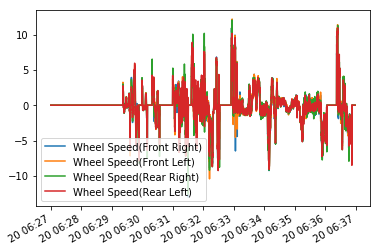

In [46]:
wheel_cols = ['Wheel Speed(Front Right)', 'Wheel Speed(Front Left)', 'Wheel Speed(Rear Right)', 'Wheel Speed(Rear Left)']
pdMultiData = data_sampled[wheel_cols].apply(lambda x: x.diff())# find difference between 2 sets
pdMultiData[wheel_cols] = pdMultiData[wheel_cols].fillna(0)
pdMultiData[wheel_cols].plot()
print(pdMultiData[wheel_cols].describe().apply(lambda x: x.map('{:,.4f}'.format)))

In [47]:
pdMultiData.rename(columns = {
    'Acceleration_Sensor_Value': 'ASV'
                              , 'Lateral_Sensor_Value':'LSV'
                              , 'Vehicle_Speed': 'VS'
                              , 'Wheel Speed(Front Left)':'FL'
                              , 'Wheel Speed(Front Right)': 'FR'
                              , 'Wheel Speed(Rear Left)':'RL'
                              , 'Wheel Speed(Rear Right)' : 'RR'
                              , 'Yaw_Rate': 'YR'
                             }, inplace = True)

In [48]:
#pdMultiData.to_csv ('C:\\Users\\SK250092\\Desktop\\Wheel_data.csv', index = True, header=True)

### Univariate Analysis
#### Data Distributions for Individual Wheel RPMs
##### Histogram Plots (normalcy check)

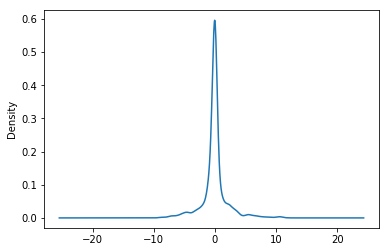

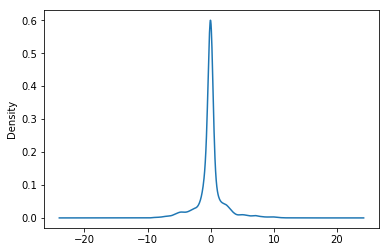

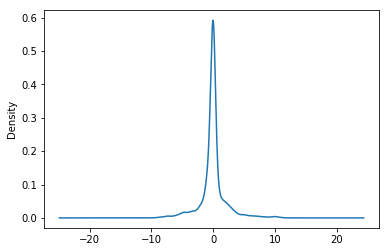

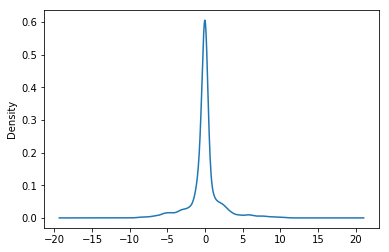

In [50]:
pdMultiData['FR'].plot(kind='kde')
plt.show()
pdMultiData['FL'].plot(kind = 'kde')
plt.show()
pdMultiData['RR'].plot(kind = 'kde')
plt.show()
pdMultiData['RL'].plot(kind = 'kde')
plt.show()

#### QQ Plot (Normalcy Check)

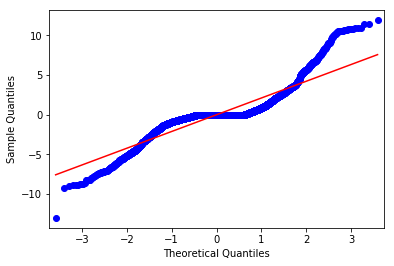

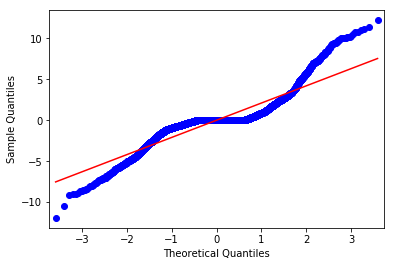

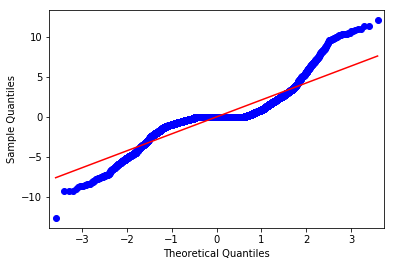

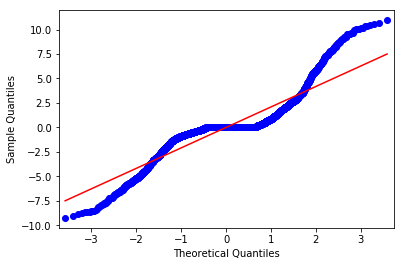

In [51]:
qqplot(pdMultiData['FR'], line='s')
plt.show()

qqplot(pdMultiData['FL'], line='s')
plt.show()

qqplot(pdMultiData['RR'], line='s')
plt.show()

qqplot(pdMultiData['RL'], line='s')
plt.show()

#### Shapiro Wilkes Test

In [52]:
stat, p = shapiro(pdMultiData['FR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('FR looks Gaussian (fail to reject H0)')
else:
    print('FR does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['FL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('FL looks Gaussian (fail to reject H0)')
else:
    print('FL does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['RR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('RR looks Gaussian (fail to reject H0)')
else:
    print('RR does not look Gaussian (reject H0)')

stat, p = shapiro(pdMultiData['RL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('RL looks Gaussian (fail to reject H0)')
else:
    print('RL does not look Gaussian (reject H0)')

Statistics=0.787, p=0.000
FR does not look Gaussian (reject H0)
Statistics=0.790, p=0.000
FL does not look Gaussian (reject H0)
Statistics=0.786, p=0.000
RR does not look Gaussian (reject H0)
Statistics=0.789, p=0.000
RL does not look Gaussian (reject H0)


C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### K^2 Test

In [53]:
stat, p = normaltest(pdMultiData['FR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('FR looks Gaussian (fail to reject H0)')
else:
	print('FR does not look Gaussian (reject H0)')

stat, p = normaltest(pdMultiData['FL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('FL looks Gaussian (fail to reject H0)')
else:
	print('FL does not look Gaussian (reject H0)')
    
stat, p = normaltest(pdMultiData['RR'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('RR looks Gaussian (fail to reject H0)')
else:
	print('RR does not look Gaussian (reject H0)')
    
stat, p = normaltest(pdMultiData['RL'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('RL looks Gaussian (fail to reject H0)')
else:
	print('RL does not look Gaussian (reject H0)')

Statistics=1134.632, p=0.000
FR does not look Gaussian (reject H0)
Statistics=1065.402, p=0.000
FL does not look Gaussian (reject H0)
Statistics=1123.830, p=0.000
RR does not look Gaussian (reject H0)
Statistics=1021.259, p=0.000
RL does not look Gaussian (reject H0)


#### Anderson-Darling Test

In [54]:
result = anderson(pdMultiData['FR'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, FR looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, FR does not look normal (reject H0)' % (sl, cv))

result = anderson(pdMultiData['FL'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, FL looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, FL does not look normal (reject H0)' % (sl, cv))

result = anderson(pdMultiData['RR'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, RR looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, RR does not look normal (reject H0)' % (sl, cv))

        
result = anderson(pdMultiData['RL'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, RL looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, RL does not look normal (reject H0)' % (sl, cv))

Statistic: 522.720
15.000: 0.576, FR does not look normal (reject H0)
10.000: 0.656, FR does not look normal (reject H0)
5.000: 0.786, FR does not look normal (reject H0)
2.500: 0.917, FR does not look normal (reject H0)
1.000: 1.091, FR does not look normal (reject H0)
Statistic: 522.650
15.000: 0.576, FL does not look normal (reject H0)
10.000: 0.656, FL does not look normal (reject H0)
5.000: 0.786, FL does not look normal (reject H0)
2.500: 0.917, FL does not look normal (reject H0)
1.000: 1.091, FL does not look normal (reject H0)
Statistic: 518.962
15.000: 0.576, RR does not look normal (reject H0)
10.000: 0.656, RR does not look normal (reject H0)
5.000: 0.786, RR does not look normal (reject H0)
2.500: 0.917, RR does not look normal (reject H0)
1.000: 1.091, RR does not look normal (reject H0)
Statistic: 528.756
15.000: 0.576, RL does not look normal (reject H0)
10.000: 0.656, RL does not look normal (reject H0)
5.000: 0.786, RL does not look normal (reject H0)
2.500: 0.917, RL

# ---------------------------------------------------------------------------------------------------------

# Non-Parametric(Univariate/Multivariate) Approaches
Nonparametric tests do not rely on any distribution. They can thus be applied even if parametric (underlying statistical distributions) conditions of validity are not met. This section will implement the below non-parametric approaches.

    - Interquartile Range (IQR) - Univariate
    - Direct Anomaly Detection 
        - Isolation Forest(Univariate/Multivariate)
    - Density-based Anomaly Detection
        - Local Outlier Factor

### Interquartile Range (IQR)  - Univariate
The IQR describes the middle 50% of values when ordered from lowest to highest. To find the interquartile range (IQR), ​first find the median (middle value) of the lower and upper half of the data. These values are quartile (Q1) and quartile (Q3). The IQR is the difference between Q3 and Q1. IQR = Q3 −  Q1

<function matplotlib.pyplot.show(*args, **kw)>

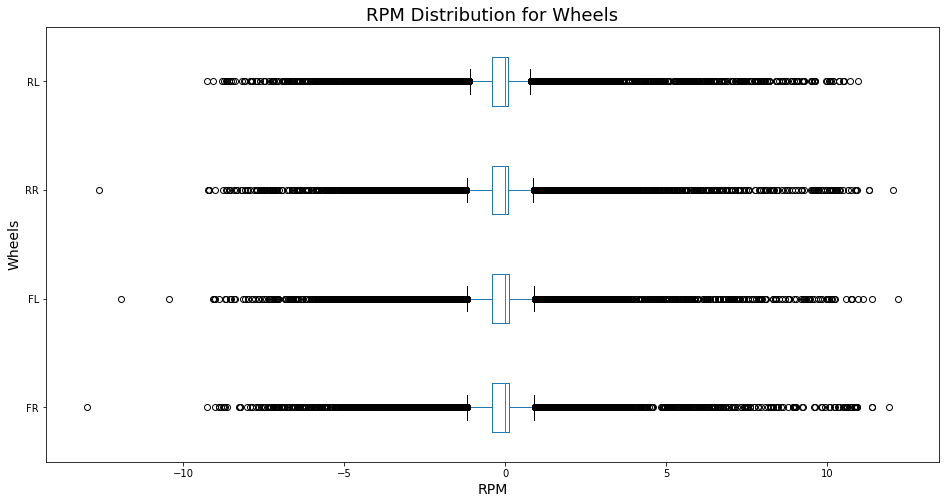

In [55]:
#Function: This function identifies the outliers/anomalies in each wheel separately using IQR approach 
#Input:    The arguments of the function take "Data of a Wheel" e.g Front Righ wheel
#Output:   Returns the values of all the outliers(anomalies)
#---------------------------------------------------------------------------------------------------------------------------
def nonparam_uni_IQR_outliers(data):
    #Find the Q3 and Q1 of data
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    #Find IQR = Q3 − Q1
    iqr = q75 - q25
    # calculate the outlier cutoff (1.5 greater than IQR)
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    return pd.DataFrame(data.iloc[np.where(data.gt(upper) | data.lt(lower))])#get greater than and lower than upper/lower limits
#----------------------------------------------------------------------------------------------------------------------------
#call the IQR function for each wheel
fr_outliers = nonparam_uni_IQR_outliers(pdMultiData['FR'])
fl_outliers = nonparam_uni_IQR_outliers(pdMultiData['FL'])
rr_outliers = nonparam_uni_IQR_outliers(pdMultiData['RR'])
rl_outliers = nonparam_uni_IQR_outliers(pdMultiData['RL'])

#box Plot the data of each wheel to visualize the outliers
df = pdMultiData
new_multi1_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
new_multi1_df.plot(kind = 'box', figsize=[16,8], vert=False)
plt.title('RPM Distribution for Wheels', fontsize=18)
plt.xlabel('RPM', fontsize=14)
plt.ylabel('Wheels', fontsize=14)
plt.show

- The above plot shows the distribution of RPM values for each wheel (Front-Right(FR), Front-Left(FL), Rear-Rigt(RR), Rear-Left(RL))
- The blue line box represents the Q1 to Q3 (50%) values, whereas the green line represents the median(Q2).
- The black dots are all the outliers 
        Outliers = Values lower than ( Q1 – 1.5 x IQR )     OR   
                   Values greater than (Q3 + 1.5 x IQR)

#### Common IQR outliers

<function matplotlib.pyplot.show(*args, **kw)>

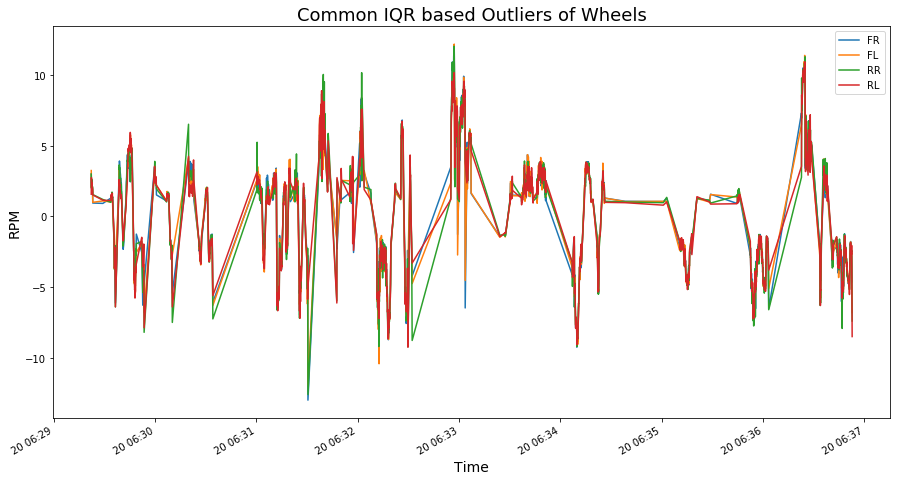

In [56]:
#Plot the common outliers in 4 wheels
dfs = [fr_outliers, fl_outliers, rr_outliers, rl_outliers]
common_outliers = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dfs)
common_outliers.plot(figsize=(15,8))
plt.title('Common IQR based Outliers of Wheels', fontsize=18)
plt.ylabel('RPM', fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.show

- The above graph shows IQR based outlier values of each wheel (Front-Right(FR), Front-Left(FL), Rear-Rigt(RR), Rear-Left(RL))
- The common outliers between each wheel overlap

## Directly Anomaly Detection
Identifies anomalies directly instead of first defining a normal behavior

### Isolation Forest 

- This is a non-parametric method for large datasets in a one or multi-dimensional feature space. And, is an example of Direct Anomaly Detection.
- A tree-based model, in which multiple trees are created randomly for a given data set, and anomalies are samples with shortest average path length.
- A data point is defined as an outlier if it can be easily isolated using only a few partitions.

Steps Involved

- STEP 1: The very first step is sampling for training a model.
- STEP 2: Make a decision tree for the sample drew from step 1 by randomly picking an attribute and value.
- STEP 3: Repeat step 2 Iteratively to create a forest or collection of trees. Steps 1-3 can be achieved using function IsolationForest()
- STEP 4: Calculate Anomaly score. decision_function() and predict() is used to find out outliers.

#### Implementation of Isolation forest for Univariate data 


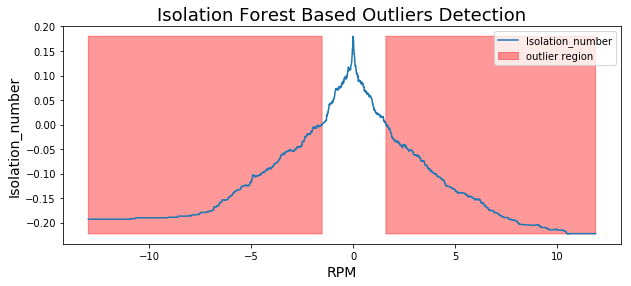

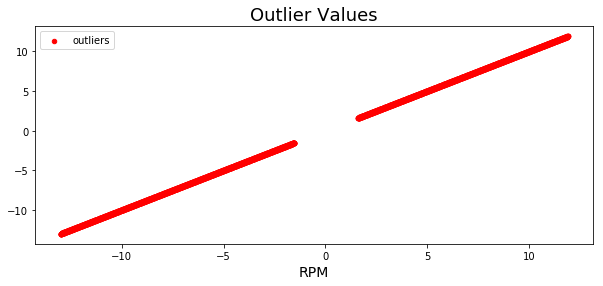

In [57]:
#Function: This function identifies the outliers/anomalies in each wheel separately using Isolation Forest approach 
#Input:    The arguments of the function take "Data of a Wheel" e.g Front Righ wheel
#Output:   Returns the values of all the outliers(anomalies)
#---------------------------------------------------------------------------------------------------------------------------

def nonparam_uni_Isolation_Forest(data):
    rng = np.random.RandomState(1042)
    # fit the model by using function I_Forest = IsolationForest()
    # attributes can also be adjusted according to requirements
    I_Forest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
    # Input the sample,Reshape (-1,1) means data rows unknown and column 1
    I_Forest.fit(data.values.reshape(-1, 1))
    #linspace function produces a evenly spaced observations within a defined interval.
    xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,1)
    # Find Isolation Number
    Isolation_number = I_Forest.decision_function(xx)
    #Predict if a particular sample is an outlier or not.(Returns (+1 or -1))
    predict_outlier = I_Forest.predict(xx)
    # create a data frame containing outlier values
    new_df= pd.DataFrame.from_records(xx)    
    outliers=new_df.iloc[predict_outlier==-1]
    #view the observations graphically
    nonparam_uni_Isolation_Forest_visualize(xx, Isolation_number, predict_outlier,outliers)
    return(outliers)
#--------------------------------------------------------------------------------------------------------------------------
#Function: This function plots the outliers/anomalies in each wheel separately using Isolation Forest approach 
#Input:    The arguments of the function take Data of a Wheel, Isolation Number, outlier predictions and the values of outliers
#Output:   Plots the graphs
#---------------------------------------------------------------------------------------------------------------------------
#Visualize
def nonparam_uni_Isolation_Forest_visualize(xx,Isolation_number, predict_outlier,outliers):
    plt.figure(figsize=(10,4))
    plt.plot(xx, Isolation_number, label='Isolation_number')
    plt.fill_between(xx.T[0], np.min(Isolation_number), np.max(Isolation_number), 
                 where=predict_outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
    plt.legend()
    plt.title('Isolation Forest Based Outliers Detection', fontsize=18)
    plt.ylabel('Isolation_number', fontsize=14)
    plt.xlabel('RPM',fontsize=14)
    plt.show()
    # Plot the compressed outlier data points
    plt.figure(figsize=(10,4))
    plt.scatter(outliers[0], outliers, s=20, label="outliers",c="Red")
    plt.title('Outlier Values', fontsize=18)
    plt.xlabel('RPM',fontsize=14)
    plt.legend()
    plt.show()
#-----------------------------------------------------------------------------------------------------------------------------  
#Call the Isolation function for each wheel's dataset  
fr_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['FR'])
#fl_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['FL'])
#rr_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['RR'])
#rl_IF_outliers = nonparam_uni_Isolation_Forest(pdMultiData['RL'])

- Isolation Forest Based Outliers Detection: The graph shows the outlier RPM values (Red region), and the blue line on the graph represents the number of splits it took to detect whether a value is an outlier or not.
- Outlier Values: The plot visualizes all the outlier values for a single wheel.

#### Isolation Forest (multivariate)

In [58]:
df = pdMultiData
new_multi_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
#new_multi_df.head()
model_columns=new_multi_df.columns
rng = np.random.RandomState(1042)
# fit the model by using function Is_Forest = IsolationForest()
# attributes can also be adjusted according to requirements
IS_Forest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
# Input the sample,Reshape (-1,1) means data rows unknown and column 1
IS_Forest = IS_Forest.fit(new_multi_df[model_columns])
#linspace function produces a evenly spaced observations within a defined interval.
#xx = np.linspace(data.min(), data.max(), len(data)).reshape(-1,4)
# Find Isolation Number/outlier score
Is_number = IS_Forest.decision_function(new_multi_df[model_columns])
#Predict if a particular sample is an outlier or not.(Returns (+1 or -1))
pred_outlier = IS_Forest.predict(new_multi_df[model_columns])
#print(pred_outlier)
# create data frame containing outlier values
new_multi_df['splits'] = Is_number
new_multi_df['Outlier'] = pred_outlier
columns = new_multi_df.columns
#new_multi_df[columns]
#Only show the outliers
new_multi_df[new_multi_df.Outlier == -1]

,FR,FL,RR,RL,splits,Outlier
2016-04-20 06:29:22.200,3.000,3.250,3.000,1.575,-0.052728,-1
2016-04-20 06:29:22.300,2.350,2.100,2.000,2.750,-0.024214,-1
2016-04-20 06:29:22.400,2.150,2.150,2.475,2.600,-0.028812,-1
2016-04-20 06:29:22.500,2.175,2.175,2.625,2.275,-0.026860,-1
2016-04-20 06:29:22.600,2.125,2.125,2.050,2.375,-0.016722,-1
2016-04-20 06:29:22.700,1.950,2.025,2.050,2.075,-0.012890,-1
2016-04-20 06:29:22.800,2.100,2.100,2.000,2.075,-0.017297,-1
2016-04-20 06:29:22.900,1.975,1.975,2.125,2.000,-0.017222,-1
2016-04-20 06:29:23.000,1.750,1.875,2.050,1.950,-0.007677,-1
2016-04-20 06:29:35.800,-3.025,-2.775,-2.675,-2.875,-0.025482,-1


## Density-based Anomaly Detection
- Density-based outlier detection method investigates the density of an object and that of its neighbors.
- An object is an outlier/anomaly if its density is relatively much lower than that of its neighbors


### Local Outlier Factor (LOF)
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. Local outlier factor is a density-based method that relies on nearest neighbors search. It considers as outlier samples that have a substantially lower density than their neighbors.

Steps Involved
- Step 1: Calculation of distance between every two data points
- Step 2: Calculation of the distance between each point and its kth nearest neighbour [distk(o)]
- Step 3: Calculation of k-distance neighbourhood of each point.
- Step 4: Calculation of local reachability density (LRD).
- Step 5: Calculation of LOFk(o).
- Step 6: Sort the LOFk(o) in descending order and pick the top n outliers.

In [59]:
df = pdMultiData
LOF_multi_df=pd.DataFrame(columns=['FR', 'FL','RR','RL'], data=df.values, index=df.index)
columns=LOF_multi_df.columns
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
pred_outliers=LOF.fit_predict(LOF_multi_df[columns])
X_scores = LOF.negative_outlier_factor_
#print(X_scores)
LOF_multi_df['outlier_score'] = X_scores
LOF_multi_df['outliers'] = pred_outliers
LOF_multi_df[LOF_multi_df.outliers == -1]
#col=LOF_multi_df.columns
#LOF_multi_df[col]

,FR,FL,RR,RL,outlier_score,outliers
2016-04-20 06:29:22.100,0.525000,0.525000,0.000000,0.675000,-1.628443e+00,-1
2016-04-20 06:29:23.600,-0.100000,0.000000,0.000000,0.000000,-9.864689e+08,-1
2016-04-20 06:29:23.700,-0.025000,0.000000,-0.175000,0.000000,-4.799574e+08,-1
2016-04-20 06:29:23.800,0.175000,0.000000,0.050000,0.000000,-4.309619e+08,-1
2016-04-20 06:29:27.800,0.000000,0.000000,-0.025000,-0.100000,-7.613504e+08,-1
2016-04-20 06:29:27.900,0.000000,0.175000,0.000000,0.000000,-6.786595e+08,-1
2016-04-20 06:29:29.500,0.075000,0.000000,0.050000,0.000000,-8.491625e+08,-1
2016-04-20 06:29:31.000,0.100000,0.075000,0.000000,-0.075000,-3.731044e+08,-1
2016-04-20 06:29:31.100,0.000000,-0.025000,0.000000,0.225000,-8.860905e+08,-1
2016-04-20 06:29:31.200,0.000000,-0.050000,0.000000,-0.150000,-6.082196e+08,-1


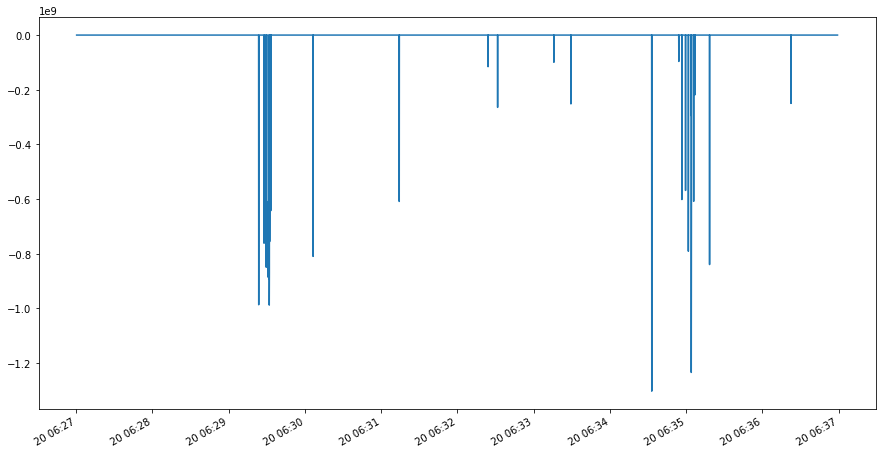

In [60]:
LOF_multi_df['outlier_score'].plot(figsize=(15,8))

#### Inconsistent Outliers between Wheels

In [33]:
df = pd.concat([fr_outliers, fl_outliers, rr_outliers, rl_outliers]) # concat dataframes
df = df.reset_index() # reset the index
mask = df.groupby(['index']).index.transform('count') == 1

# [df[mask]['index']]
inconsistent_outliers = pd.DataFrame(df[mask]['index'])
pdMultiData.join(inconsistent_outliers)

inconsistent_outliers = pd.merge(pdMultiData, inconsistent_outliers, left_index=True, right_on='index').set_index('index')

C:\Users\SK250092\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
